In [1]:
import glob
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import squidpy as sq
import gc
import hdf5plugin
import torch
import torch.nn as nn
import sys
sys.path.append("../")

import sklearn.cluster as cluster
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader
from sklearn.metrics import adjusted_rand_score as ari_score, normalized_mutual_info_score as nmi_score



In [2]:
df = pd.read_csv('../Results/Summary/func_summary.csv')

In [3]:
df.groupby(["Dataset", "Gene"]).agg({"Moran'I_Score": "median"})
# .sort_values(by=["Moran'I_Score"], ascending=False).head()

Moran'I_Score
Dataset   Gene                  
BC_Her2ST A2M           0.099471
          ABL1          0.079177
          ABL2          0.031293
          ACTN1         0.074009
          ACTN4         0.098227
...                          ...
Skin_cSCC ZFP36L1       0.133126
          ZFP36L2       0.152222
          ZIC2          0.006271
          ZNF205        0.046241
          ZNF750        0.113325

[8034 rows x 1 columns]

In [4]:
# Rank gene by median Moran'I score
result = df.groupby(["Dataset", "Gene"]).agg({"Pearson correlation": "median"})

# Get the top 1 genes for each dataset
top_genes = result.groupby('Dataset')["Pearson correlation"].nlargest(5).to_frame()

# Display the top genes
top_genes


Pearson correlation
Dataset       Dataset       Gene                         
BC_Her2ST     BC_Her2ST     CD24                 0.327777
                            GNAS                 0.308788
                            ERBB2                0.302989
                            HSP90B1              0.254337
                            CD46                 0.252262
BC_visium     BC_visium     GNAS                 0.221495
                            MARCKSL1             0.213493
                            GTF2I                0.192854
                            PRKDC                0.188577
                            LAMP1                0.187727
Kidney_visium Kidney_visium CD74                 0.133786
                            HLA-E                0.126348
                            DDIT4                0.124769
                            CTSB                 0.118138
                            CTNNA1               0.117140
Liver_visium  Liver_visium  APOE                 0.739997
                            C1S                  0.736284
                            CLU                  0.731543
                            APOB                 0.730733
                            SERPING1             0.719802
Skin_Melanoma Skin_Melanoma HSPB1                0.391589
                            PFN1                 0.364277
                            CALML5               0.364199
                            ANXA2                0.362854
                            APOE                 0.341778
Skin_cSCC     Skin_cSCC     PFN1                 0.427614
                            TAPBP                0.353403
                            CD44                 0.336353
                            CTSD                 0.334822
                            ANXA2                0.328456

In [88]:
# Rank gene by median Moran'I score
result = df.groupby(["Dataset", "Gene"]).agg({"Moran'I_Score": "median"})

# Get the top 1 genes for each dataset
top_genes = result.groupby('Dataset')["Moran'I_Score"].nlargest(5).to_frame()

# Display the top genes
top_genes


Moran'I_Score
Dataset       Dataset       Gene                   
BC_Her2ST     BC_Her2ST     CD24           0.235582
                            GNAS           0.233832
                            ERBB2          0.231347
                            SDC1           0.189843
                            XBP1           0.186415
BC_visium     BC_visium     EPCAM          0.181461
                            MARCKSL1       0.173720
                            GNAS           0.172431
                            ILF3           0.155466
                            GTF2I          0.152372
Kidney_visium Kidney_visium CD74           0.119223
                            CD63           0.106299
                            CTSB           0.103307
                            DDIT4          0.100712
                            B2M            0.098195
Liver_visium  Liver_visium  APOE           0.699360
                            CLU            0.691601
                            C1S            0.686305
                            SERPING1       0.682490
                            AMBP           0.677819
Skin_Melanoma Skin_Melanoma APOE           0.332874
                            PFN1           0.311879
                            S100A10        0.311151
                            S100A9         0.308754
                            HSPB1          0.299523
Skin_cSCC     Skin_cSCC     PFN1           0.323292
                            SFN            0.285504
                            CD44           0.285203
                            CTSD           0.273022
                            IFI27          0.267440

In [99]:
import scanpy as sc
import matplotlib.pyplot as plt
import gc
import glob

def plot_gene_expression(ax, data, gene, title, model_name=None, img=None):
    sc.pl.spatial(data, color=gene, show=False, img_key=img, frameon=False,
                  title=title, legend_fontsize="x-large", ax=ax, colorbar_loc=None)
    if model_name is not None:
        ax.set_title(model_name, fontsize="x-large")

def refine_model_name(model_name):
    if model_name == "stimage":
        return "STimage"
    elif model_name == "stnet":
        return "STNet"
    elif model_name == "hist2st":
        return "Hist2ST"
    elif model_name == "histogene":
        return "HisToGene"
    elif model_name == "deepspace":
        return "DeepSpaCE"
    elif model_name == "deeppt":
        return "DeepPT"
    elif model_name == "bleep":
        return "BLEEP"
    else:
        return model_name

def splot_exp(dataset_name, slide, target_gene, gt_path):
    fig, axs = plt.subplots(1, 9, figsize=(24, 8))

    tmp = sc.read_h5ad(gt_path)
    gt = sc.read_h5ad(f"../Results/{dataset_name}/gt_stimage_{dataset_name}_reinhard_{slide}_func.h5ad")
    gt.uns = tmp.uns

    sc.pl.spatial(gt, color=None, show=False, frameon=False, title="H&E image", legend_fontsize="x-large", ax=axs[0], )
    # colorbar_loc=None
    axs[0].set_title("H&E image", fontsize="x-large")

    plot_gene_expression(axs[1], gt, target_gene, "Observed Gene Expression")

    i = 2
    for model_name in ["stimage", "stnet", "hist2st", "histogene", "deepspace", "deeppt", "bleep"]:
        pred = sc.read_h5ad(f"../Results/{dataset_name}/pred_{model_name}_{dataset_name}_reinhard_{slide}_func.h5ad")
        gt = sc.read_h5ad(f"../Results/{dataset_name}/gt_{model_name}_{dataset_name}_reinhard_{slide}_func.h5ad")
        gt.uns = tmp.uns
        gt.X = pred.X

        model_name_display = refine_model_name(model_name)
        plot_gene_expression(axs[i], gt, target_gene, model_name_display, model_name_display,img=None)
        i += 1
        
    plt.show()
    plt.savefig(f"../Results/Figures/Vis_Exp/{dataset_name}_{slide}_{target_gene}.pdf", dpi=300)
    gc.collect()


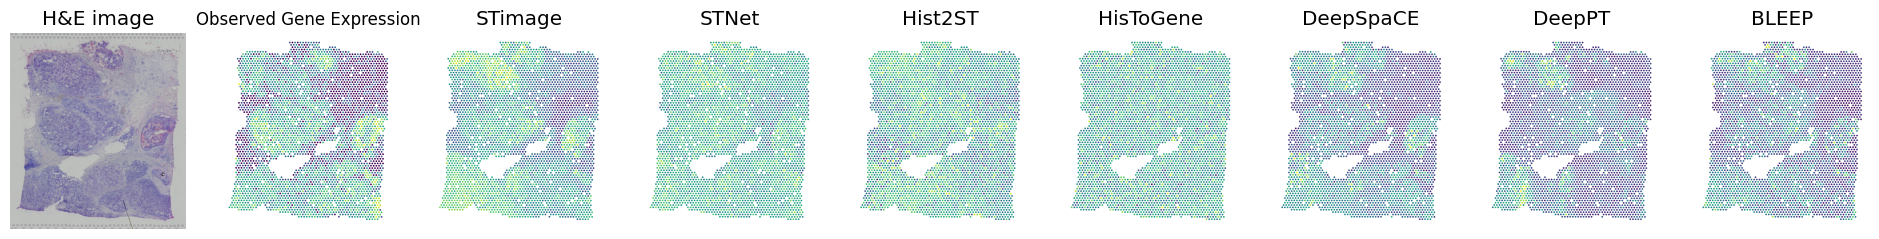

In [103]:
dataset_name = "BC_visium"
slide = "block1"
target_gene = "EPCAM"
gt_path = f"../Dataset/{dataset_name}/{slide}.h5ad"
splot_exp(dataset_name, slide, target_gene, gt_path)


/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


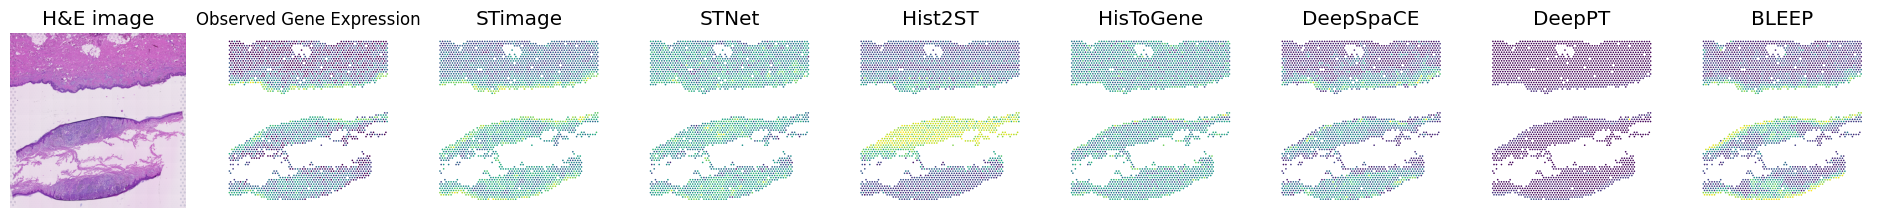

In [100]:
dataset_name = "Skin_Melanoma"
slide = "Visium38_D1"
target_gene = "HSPB1"
gt_path = f"../Dataset/{dataset_name}/processed_data/{slide}.h5ad"
splot_exp(dataset_name, slide, target_gene, gt_path)


In [145]:
ls ../Dataset/Kidney_visium

A/  B/  C/  D/  Processed_Data/  Visium14_C/  Visium14_D/


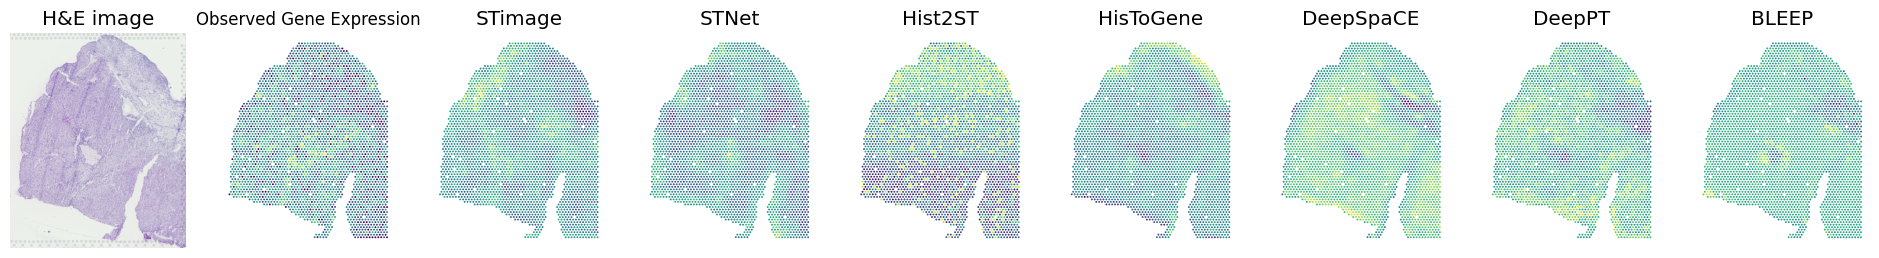

In [117]:
dataset_name = "Kidney_visium"
slide = "A"
target_gene = "CD74"
gt_path = f"../Dataset/{dataset_name}/Processed_Data/{slide}.h5ad"
splot_exp(dataset_name, slide, target_gene, gt_path)


/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


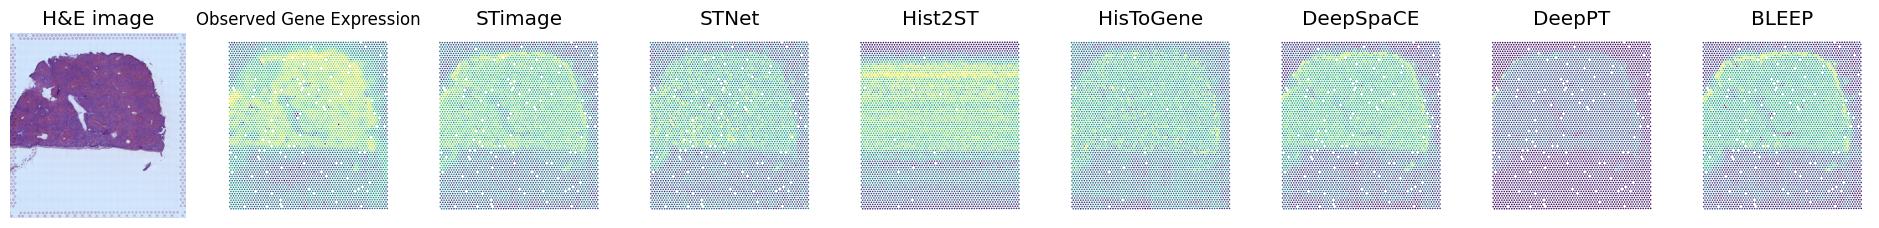

In [124]:
dataset_name = "Liver_visium"
slide = "C73_C1_VISIUM"
target_gene = "APOE"
gt_path = f"../Dataset/{dataset_name}/GSE240429/{slide}.h5ad"
splot_exp(dataset_name, slide, target_gene, gt_path)


/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (91863954 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


21255

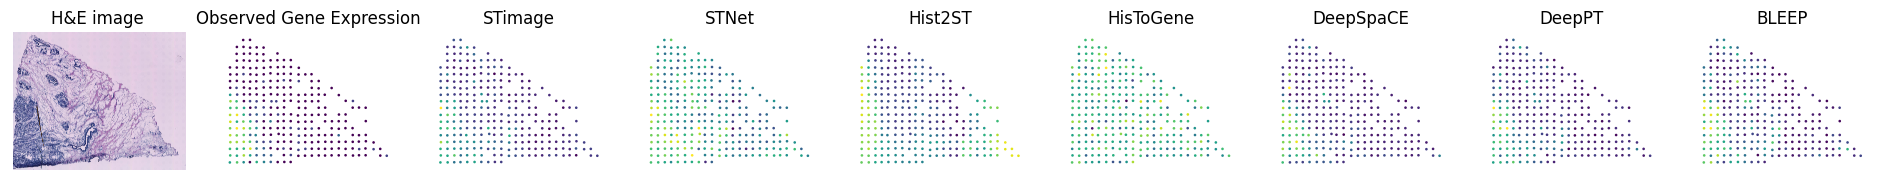

In [138]:
import scanpy as sc
import matplotlib.pyplot as plt
import glob
import gc
from PIL import Image
import numpy as np

def load_gt_data(dataset_name, model_name, slide):
    return sc.read_h5ad(f"../Results/{dataset_name}/gt_{model_name}_{dataset_name}_reinhard_{slide}_func.h5ad")

def load_pred_data(dataset_name, model_name, slide):
    return sc.read_h5ad(f"../Results/{dataset_name}/pred_{model_name}_{dataset_name}_reinhard_{slide}_func.h5ad")

def plot_spatial(gt, axs, title):
    sc.pl.spatial(gt, color="CD24", spot_size=112, show=False, frameon=False,
                  title=title, legend_fontsize="x-large", ax=axs, colorbar_loc=None)

def refine_model_name(model_name):
    model_name_mapping = {
        "stimage": "STimage",
        "stnet": "STNet",
        "hist2st": "Hist2ST",
        "histogene": "HisToGene",
        "deepspace": "DeepSpaCE",
        "deeppt": "DeepPT",
        "bleep": "BLEEP"
    }
    return model_name_mapping.get(model_name, model_name)

dataset_name = "BC_Her2ST"
slide = "B2"
target_gene = "CD24"

fig, axs = plt.subplots(1, 9, figsize=(24, 8))

gt = load_gt_data(dataset_name, "stimage", slide)

# Plot the H&E image
image_path = "../Dataset/her2st/data/ST-imgs/B/B2/BT10737_C2_HE.jpg"

# Open the image using Pillow
img = Image.open(image_path)

# Convert the image to a NumPy array
img = np.array(img)

sc.pl.spatial(gt, color=None, spot_size=112, show=False, frameon=False, img=img,
                  title="H&E image", legend_fontsize="x-large", ax=axs[0], colorbar_loc=None)

# Plot the observed gene expression
plot_spatial(gt, axs[1], "Observed Gene Expression")

# Plot the predicted gene expression
i = 2
for model_name in ["stimage", "stnet", "hist2st", "histogene", "deepspace", "deeppt", "bleep"]:
    model_name_refined = refine_model_name(model_name)

    gt = load_gt_data(dataset_name, model_name, slide)
    pred = load_pred_data(dataset_name, model_name, slide)
    pred.obsm = gt.obsm
    plot_spatial(pred, axs[i], model_name_refined)

    i += 1

plt.savefig(f"../Results/Figures/Vis_Exp/{dataset_name}_{slide}_{target_gene}.pdf", dpi=300)
gc.collect()


25185

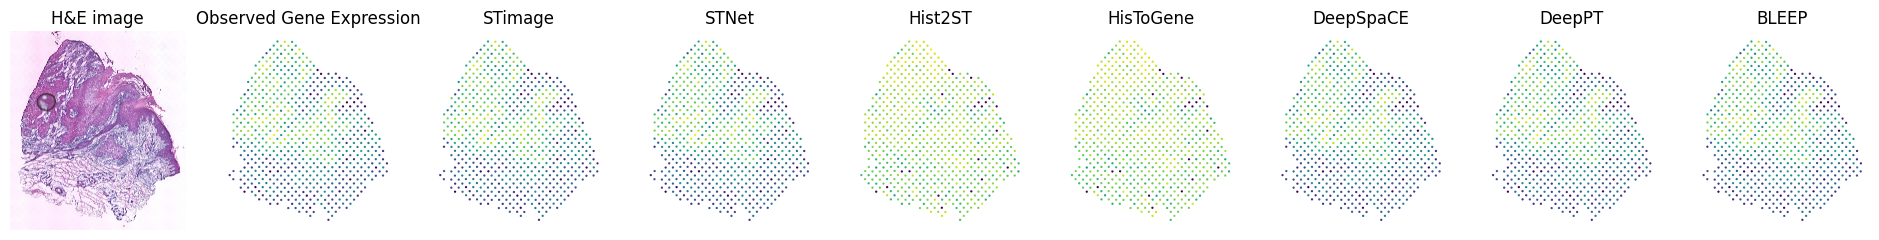

In [144]:
import scanpy as sc
import matplotlib.pyplot as plt
import glob
import gc
from PIL import Image
import numpy as np
Image.MAX_IMAGE_PIXELS = None

def load_data(dataset_name, model_name, slide):
    return sc.read_h5ad(f"../Results/{dataset_name}/gt_{model_name}_{dataset_name}_reinhard_{slide}_func.h5ad")

def plot_spatial(gt, axs, title):
    sc.pl.spatial(gt, color="PFN1", spot_size=112, show=False, frameon=False,
                  title=title, legend_fontsize="x-large", ax=axs, colorbar_loc=None)

def refine_model_name(model_name):
    model_name_mapping = {
        "stimage": "STimage",
        "stnet": "STNet",
        "hist2st": "Hist2ST",
        "histogene": "HisToGene",
        "deepspace": "DeepSpaCE",
        "deeppt": "DeepPT",
        "bleep": "BLEEP"
    }
    return model_name_mapping.get(model_name, model_name)

dataset_name = "Skin_cSCC"
slide = "P2_ST_rep1"
target_gene = "PFN1"

fig, axs = plt.subplots(1, 9, figsize=(24, 8))

gt = load_data(dataset_name, "stimage", slide)

# Plot the H&E image
image_path = "../Dataset/CSCC/GSM4284316_P2_ST_rep1.jpg"

# Open the image using Pillow
img = Image.open(image_path)

# Convert the image to a NumPy array
img = np.array(img)

sc.pl.spatial(gt, color=None, spot_size=112, show=False, frameon=False, img=img,
                  title="H&E image", legend_fontsize="x-large", ax=axs[0], colorbar_loc=None)

# Plot the observed gene expression
plot_spatial(gt, axs[1], "Observed Gene Expression")

# Plot the predicted gene expression
i = 2
for model_name in ["stimage", "stnet", "hist2st", "histogene", "deepspace", "deeppt", "bleep"]:
    model_name_refined = refine_model_name(model_name)

    gt = load_data(dataset_name, model_name, slide)
    plot_spatial(gt, axs[i], model_name_refined)
    i += 1

# plt.savefig(f"../Results/Figures/Vis_Exp/{dataset_name}_{slide}_{target_gene}.pdf", dpi=300)
gc.collect()



# Crop the color bar

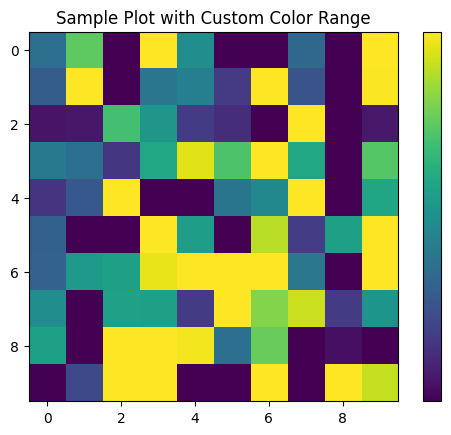

In [84]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

# Create sample data
data = np.random.random((10, 10)) * 100  # Random data between 0 and 100

# Set the desired range for color mapping
low_value = 20
high_value = 80

# Create a Normalize object to map the data to the color range
norm = Normalize(vmin=low_value, vmax=high_value)

# Create a sample plot with color mapping
fig, ax = plt.subplots()
cax = ax.imshow(data, cmap='viridis', norm=norm)
ax.set_title('Sample Plot with Custom Color Range')

# Create a color bar independently
cbar = plt.colorbar(cax)

# Hide the numerical values in the color bar
cbar.ax.set_yticks([])  # Use set_xticks([]) for horizontal color bars

# Show the plot
plt.show()
